# Understanding Convolutional layer

What is the difference between convolutional layer and linear layer?
What kind of intuition is in behind of using convolutional layer in deep neural network?

This hands on shows some effects by convolutional layer to provide some intution about what convolutional layer do.

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

basedir = './src/cnn/images'


def read_rgb_image(imagepath):
    image = cv2.imread(imagepath)  # Height, Width, Channel
    (major, minor, _) = cv2.__version__.split(".")
    if major == '3':
        # version 3 is used, need to convert
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        # Version 2 is used, not necessary to convert
        pass
    return image


def read_gray_image(imagepath):
    image = cv2.imread(imagepath)  # Height, Width, Channel
    (major, minor, _) = cv2.__version__.split(".")
    if major == '3':
        # version 3 is used, need to convert
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # Version 2 is used, not necessary to convert
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image


def plot_channels(array, filepath='out.jpg'):
    """Plot each channel component separately

    Args:
        array (numpy.ndarray): 3-D array (width, height, channel)

    """
    ch_number = array.shape[2]

    fig, axes = plt.subplots(1, ch_number)
    for i in range(ch_number):
        # Save each image
        # cv2.imwrite(os.path.join(basedir, 'output_conv1_{}.jpg'.format(i)), array[:, :, i])
        axes[i].set_title('Channel {}'.format(i))
        axes[i].axis('off')
        axes[i].imshow(array[:, :, i], cmap='gray')

    plt.savefig(filepath)

![CNN diagram](assets/cnn_diagram.png)

Above type of diagram often appears in Convolutional neural network field.
Below figure explains its notation.

![CNN diagram notation](assets/cnn_diagram_notation.png "title")

Cuboid represents the "image" array where this image might not mean the meaningful picture. 
Horizontal axis represents channel number, vertical axis for image height and depth axis for image width respectively.

## convolution layer - basic usage

Input format of convolutional layer is in the order, (batch index, channel, height, width).
Since openCV image format is in the order (height, width, channel), this dimension order 
need to be converted to input to convolution layer.

It can be done by using `transpose` method.


`L.Convolution2D(in_channels, out_channels, ksize)`
 - `in_channels`:  input channel number. 
 - `out_channels`: output channel number.
 - `ksize`:        kernel size.

image.shape (Height, Width, Channel) =  (380, 512, 3)
image shape (1, 3, 380, 512)
shape (1, 3, 376, 508)
shape 2 (376, 508, 3)


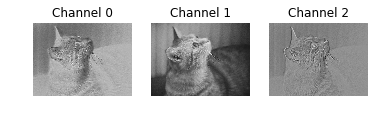

In [3]:
import chainer
import chainer.functions as F
import chainer.links as L

# Read image from file, save image with matplotlib using `imshow` function
imagepath = os.path.join(basedir, 'sample.jpeg')

image = read_rgb_image(imagepath)

# height and width shows pixel size of this image 
# Channel=3 indicates the RGB channel 
print('image.shape (Height, Width, Channel) = ', image.shape)

conv1 = L.Convolution2D(None, 3, 5)

# Need to input image of the form (batch index, channel, height, width)
image = image.transpose(2, 0, 1)
image = image[np.newaxis, :, :, :]

# Convert from int to float
image = image.astype(np.float32)
print('image shape', image.shape)
out_image = conv1(image).data
print('shape', out_image.shape)
out_image = out_image[0].transpose(1, 2, 0)
print('shape 2', out_image.shape)
plot_channels(out_image,
              filepath=os.path.join(basedir, 'output_conv1.jpg'))

#plt.imshow(image)
#plt.savefig('./src/cnn/images/out.jpg')

Convolution2D layer takes 4-dim array as input and outputs 4-dim array.
Graphical meaning of this input-output relation ship is drawn in below figure.

![conv1](assets/convolution_layer.png)

When the `in_channels` is set to None, its size is determined at the first time when it is used.
i.e., `out_image = conv1(image).data` in above code.

The internal parameter `W` is initialized randomly at that time.
As you can see, output_conv1.jpg shows the result after random filter is applied.

__Some "feature" can be extracted by applying convolution layer.__

For example, random fileter sometimes acts as "blurring" or "edge extracting" image.

To understand the intuitive meaning of convolutional layer in more detail, please see below example.

In [5]:
gray_image = read_gray_image(imagepath)
print('gray_image.shape (Height, Width) = ', gray_image.shape)

# Need to input image of the form (batch index, channel, height, width)
gray_image = gray_image[np.newaxis, np.newaxis, :, :]
# Convert from int to float
gray_image = gray_image.astype(np.float32)

conv_vertical = L.Convolution2D(1, 1, 3)
conv_horizontal = L.Convolution2D(1, 1, 3)

print(conv_vertical.W.data)
conv_vertical.W.data = np.asarray([[[[-1., 0, 1], [-1, 0, 1], [-1, 0, 1]]]])
conv_horizontal.W.data = np.asarray([[[[-1., -1, -1], [0, 0., 0], [1, 1, 1]]]])

print('image.shape', image.shape)
out_image_v = conv_vertical(gray_image).data
out_image_h = conv_horizontal(gray_image).data
print('out_image_v.shape', out_image_v.shape)
out_image_v = out_image_v[0].transpose(1, 2, 0)
out_image_h = out_image_h[0].transpose(1, 2, 0)
print('out_image_v.shape (after transpose)', out_image_v.shape)

cv2.imwrite(os.path.join(basedir, 'output_conv_vertical.jpg'), out_image_v[:, :, 0])
cv2.imwrite(os.path.join(basedir, 'output_conv_horizontal.jpg'), out_image_h[:, :, 0])

gray_image.shape (Height, Width) =  (380, 512)
[[[[-0.3449553  -0.13792285 -0.54777902]
   [ 0.38658479  0.09196359  0.03433412]
   [-0.78873783 -0.02725461  0.47162846]]]]
image.shape (1, 3, 380, 512)
out_image_v.shape (1, 1, 378, 510)
out_image_v.shape (after transpose) (378, 510, 1)


True

## Convolution with stride

The default value of `stride` is 1.
If this value is specified, convolution layer will reduce output image size.

Practically, stride=2 is often used to generate the output image of the height & width almost half of the input image.

![Convolutional layer with stride 2](assets/conv_layer_stride2.png)


image.shape (Height, Width, Channel) =  (1, 3, 380, 512)
input image.shape (1, 3, 380, 512)
out_image.shape (1, 5, 187, 253)


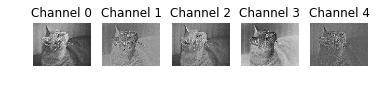

In [6]:
print('image.shape (Height, Width, Channel) = ', image.shape)

conv2 = L.Convolution2D(None, 5, 3, 2)

print('input image.shape', image.shape)
out_image = conv2(conv1(image)).data
print('out_image.shape', out_image.shape)
out_image = out_image[0].transpose(1, 2, 0)
plot_channels(out_image,
              filepath=os.path.join(basedir, 'output_conv2.jpg'))

#plt.imshow(image)
#plt.savefig('./src/cnn/images/out.jpg')

As written in the [Chainer docs](http://docs.chainer.org/en/latest/reference/functions.html#convolution-2d), 
the input and output shape relation is given in below formula:

$$ h_O = (h_I + 2h_P - h_K) / s_Y + 1 $$
$$ w_O = (w_I + 2w_P - w_K) / s_X + 1 $$

where each symbol means that 
- h: height
- w: width
- I: input
- O: output
- P: padding
- K: kernel size
- s: stride

## Max pooling

Convolution layer with stride can be used to look wide range feature,
another popular method is to use max pooling.

In [ ]:
print('image.shape (Height, Width, Channel) = ', image.shape)

print('input image.shape', image.shape)
out_image = conv2(conv1(image)).data
print('out_image.shape', out_image.shape)
out_image = out_image[0].transpose(1, 2, 0)
plot_channels(out_image,
              filepath=os.path.join(basedir, 'output_conv2.jpg'))



In [ ]:
## Convolutional neural network